In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import xgboost as xgb
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [3]:
model_path_name = "imbalanced_adv_no_pid"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

In [4]:
if not os.path.exists(DIRECTORY_PATH):
    os.makedirs(DIRECTORY_PATH)
with open(MODEL_INFO_FILEPATH, "w") as text_file:
    print(f"##### MODEL INFO #####", file=text_file)
    print(f"Weighted, no pitcher id, advanced_dataset (no fully properly tuned)", file=text_file)

In [5]:
dataset = pd.read_pickle("data/advanced_dataset_final.pkl")

In [6]:
print(dataset.shape[0]*.80)
print(dataset.shape[0]*.10)

569472.8
71184.1


In [7]:
train_index_stop = 569484 # this is the first index of a new pitcher
val_index_stop = 640690 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

In [8]:
train_X = training_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1)
train_y = training_set['pitch_type']
train_weights = training_set['type_confidence']

val_X = validation_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1)
val_y = validation_set['pitch_type']
val_weights = validation_set['type_confidence']

test_X = test_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1)
test_y = test_set['pitch_type']
test_weights = test_set['type_confidence']

In [9]:
mapping = {'FF' : 0,
           'SL': 1, 
           'CU': 2, 
           'SI': 3, 
           'FC': 4, 
           'FT': 5, 
           'KC': 6, 
           'CH': 7, 
           'KN': 8, 
           'FS': 9, 
           'FO': 10, 
           'EP': 11, 
           'SC': 12}

In [10]:
train_y = train_y.map(mapping)
val_y = val_y.map(mapping)
test_y = test_y.map(mapping)

In [11]:
weights = {
    0:1,
    1:2,
    2:3,
    3:2,
    4:3,
    5:2,
    6:4,
    7:3,
    8:4,
    9:4,
    10:4,
    11:4,
    12:4
}
# don't want fully balanced bc don't care too much about extremes
train_sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train_y #provide your own target name
)
val_sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=val_y #provide your own target name
)
test_sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=test_y #provide your own target name
)

In [12]:
train_y.value_counts(normalize=True)

pitch_type
0     0.332569
1     0.154693
3     0.125965
5     0.113138
7     0.102902
2     0.078875
4     0.058010
9     0.014640
6     0.011911
8     0.006457
10    0.000518
11    0.000177
12    0.000146
Name: proportion, dtype: float64

In [13]:
train_y

353274    0
353275    0
353276    0
353277    0
353278    0
         ..
352687    5
352688    0
352689    7
352690    0
352691    7
Name: pitch_type, Length: 569484, dtype: category
Categories (13, int64): [7, 2, 11, 4, ..., 8, 12, 3, 1]

In [14]:
bparams = {'max_depth': 6,
 'learning_rate': 0.23414476853402916,
 'n_estimators': 800,
 'subsample': 0.7000000000000001,
 'min_child_weight': 4}

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                                        objective='objective=multi:softprob', eval_metric=['merror','mlogloss'], **bparams)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], 
        sample_weight=train_sample_weights)#, sample_weight_eval_set=val_sample_weights.reshape(1,-1))

[0]	validation_0-merror:0.64471	validation_0-mlogloss:2.25602
[1]	validation_0-merror:0.64239	validation_0-mlogloss:2.08956
[2]	validation_0-merror:0.63905	validation_0-mlogloss:1.96879
[3]	validation_0-merror:0.63566	validation_0-mlogloss:1.87841
[4]	validation_0-merror:0.63170	validation_0-mlogloss:1.80495
[5]	validation_0-merror:0.63049	validation_0-mlogloss:1.74811
[6]	validation_0-merror:0.62926	validation_0-mlogloss:1.70115
[7]	validation_0-merror:0.62867	validation_0-mlogloss:1.66273
[8]	validation_0-merror:0.62606	validation_0-mlogloss:1.63085
[9]	validation_0-merror:0.62476	validation_0-mlogloss:1.60264
[10]	validation_0-merror:0.62384	validation_0-mlogloss:1.57942
[11]	validation_0-merror:0.62360	validation_0-mlogloss:1.56014
[12]	validation_0-merror:0.62225	validation_0-mlogloss:1.54230
[13]	validation_0-merror:0.62120	validation_0-mlogloss:1.52748
[14]	validation_0-merror:0.62021	validation_0-mlogloss:1.51397
[15]	validation_0-merror:0.61948	validation_0-mlogloss:1.50273
[1

KeyboardInterrupt: 

In [12]:
# clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
#                                         objective='objective=multi:softmax', eval_metric=['merror','mlogloss'])
# clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

In [12]:
def objective(trial, train_X, train_y, val_X, val_y, train_weights=None, val_weights=None):
    param = {
             "max_depth": trial.suggest_int('max_depth', 2, 20,step=1),
              "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
              "n_estimators": trial.suggest_int('n_estimators', 50, 2950,step=100),
              "subsample" : trial.suggest_float('subsample', 0.1, 1, step=0.1),
              "min_child_weight" : trial.suggest_int('min_child_weight', 1, 10, step=1), 
              "colsample_bytree" : trial.suggest_float('subsample', 0.1, 1, step=0.1),
            }
    OBJECTIVE_FUNC = 'objective=multi:softprob'
    clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                            objective=OBJECTIVE_FUNC, eval_metric=['merror','mlogloss'], **param)
    
    if train_weights is None:
      clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=0)
    else:
       clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], 
               sample_weight=train_weights, sample_weight_eval_set=val_weights, verbose=0)
    
    best_merror = clf.evals_result()['validation_0']['merror'][clf.best_iteration]
    return best_merror


In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda x : objective(x, train_X, train_y, val_X, val_y, train_weights, val_weights.values.reshape(1,-1)), n_trials=15)
print(study.best_trial)

[I 2024-04-21 20:40:16,740] A new study created in memory with name: no-name-4eb73735-cbcd-4f7a-9f42-551745e44d98
/Users/scottmaran/.pyenv/versions/3.8.18/envs/swish_bb/lib/python3.8/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [50, 2950].
  warnings.warn(
[I 2024-04-21 20:41:46,130] Trial 0 finished with value: 0.5109458682845043 and parameters: {'max_depth': 3, 'learning_rate': 0.4113835235262956, 'n_estimators': 1450, 'subsample': 0.7000000000000001, 'min_child_weight': 9}. Best is trial 0 with value: 0.5109458682845043.
/Users/scottmaran/.pyenv/versions/3.8.18/envs/swish_bb/lib/python3.8/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [50, 2950].
  warnings.warn(
[I 2024-04-21 20:43:47,649] Trial 1 finished with value: 0.

FrozenTrial(number=11, state=TrialState.COMPLETE, values=[0.499969925332766], datetime_start=datetime.datetime(2024, 4, 21, 21, 28, 13, 157604), datetime_complete=datetime.datetime(2024, 4, 21, 21, 50, 27, 316389), params={'max_depth': 14, 'learning_rate': 0.010038806810014286, 'n_estimators': 2950, 'subsample': 0.8, 'min_child_weight': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=20, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=2950, log=False, low=50, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=11, value=None)


In [14]:

print(f"Best Params = {study.best_params}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Params = {study.best_params}", file=text_file)

Best Params = {'max_depth': 14, 'learning_rate': 0.010038806810014286, 'n_estimators': 2950, 'subsample': 0.8, 'min_child_weight': 8}


In [15]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                                        objective='objective=multi:softprob', eval_metric=['merror','mlogloss'], **study.best_params)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], sample_weight=train_weights, sample_weight_eval_set=val_weights.values.reshape(1,-1))

[0]	validation_0-merror:0.54026	validation_0-mlogloss:2.54502
[1]	validation_0-merror:0.52656	validation_0-mlogloss:2.52559
[2]	validation_0-merror:0.52059	validation_0-mlogloss:2.50690
[3]	validation_0-merror:0.52023	validation_0-mlogloss:2.48869
[4]	validation_0-merror:0.51478	validation_0-mlogloss:2.47101
[5]	validation_0-merror:0.51529	validation_0-mlogloss:2.45371
[6]	validation_0-merror:0.51611	validation_0-mlogloss:2.43699
[7]	validation_0-merror:0.51490	validation_0-mlogloss:2.42062
[8]	validation_0-merror:0.51521	validation_0-mlogloss:2.40472
[9]	validation_0-merror:0.51484	validation_0-mlogloss:2.38912
[10]	validation_0-merror:0.51344	validation_0-mlogloss:2.37396
[11]	validation_0-merror:0.51354	validation_0-mlogloss:2.35922
[12]	validation_0-merror:0.51262	validation_0-mlogloss:2.34475
[13]	validation_0-merror:0.51224	validation_0-mlogloss:2.33066
[14]	validation_0-merror:0.51213	validation_0-mlogloss:2.31685
[15]	validation_0-merror:0.51245	validation_0-mlogloss:2.30337
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.010038806810014286, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2950, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:
pickle.dump(clf, open(f"{DIRECTORY_PATH}/xgb_model.pkl", "wb"))

In [17]:
best_val_merror = clf.evals_result()['validation_0']['merror'][clf.best_iteration]
best_val_mlogloss = clf.evals_result()['validation_0']['mlogloss'][clf.best_iteration]

print(f"Best Val merror = {best_val_merror}")
print(f"Best Val mlogloss = {best_val_mlogloss}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Val merror = {best_val_merror}", file=text_file)
    print(f"Best Val mlogloss = {best_val_mlogloss}", file=text_file)

Best Val merror = 0.5000596813652675
Best Val mlogloss = 1.159204095735468


In [18]:
#y_pred_probs = clf.predict_proba(val_X)

In [19]:
# y_pred_probs = clf.predict_proba(val_X)
y_pred = clf.predict(val_X)

print('\n------------------ Confusion Matrix -----------------\n')
cmatrix = confusion_matrix(val_y, y_pred)
print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)


------------------ Confusion Matrix -----------------

       FF    SL    CU    SI    FC    FT   KC    CH   KN   FS  FO  EP  SC
FF  17152  2687   810   540   535  1569  102   898  122  176   1   1   3
SL   4392  4548   222   591    93   784   10   243    0   74   0   0   7
CU   2000   516  1422   247   342   585    0   334   17   45   0   0   1
SI    958  1924   478  3444   292    30   41   850    0  143   0   0   1
FC   1378   204   267   217  1613   220   22   282    0    4   0   0   0
FT   2659   925   419    15   186  3782   12   369    0   43   1   0   6
KC    370    10     0    86    28    44  217    74    0    0   0   0   0
CH   2685   620   342   525   236   851   63  1533    0    9   0   0   0
KN     19     0     0     0     0     0    0     0  447    0   0   1   0
FS    440    97    49   114    28   107    0    16    0  285   0   0   0
FO     10     0     0     0     0     0    0     0    0    0   4   0   0
EP      2     4     1     0     0     0    0     0   12    0   0   0

In [20]:
# row i represents all true class i
# recall = (np.diagonal(confusion_matrix)/np.sum(confusion_matrix,axis=1)).round(3)
print(classification_report(val_y, y_pred, target_names=list(mapping.keys())))

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(val_y, y_pred, target_names=list(mapping.keys())), file=text_file)

              precision    recall  f1-score   support

          FF       0.53      0.70      0.61     24596
          SL       0.39      0.41      0.40     10964
          CU       0.35      0.26      0.30      5509
          SI       0.60      0.42      0.49      8161
          FC       0.48      0.38      0.43      4207
          FT       0.47      0.45      0.46      8417
          KC       0.46      0.26      0.33       829
          CH       0.33      0.22      0.27      6864
          KN       0.75      0.96      0.84       467
          FS       0.37      0.25      0.30      1136
          FO       0.67      0.29      0.40        14
          EP       0.00      0.00      0.00        19
          SC       0.38      0.48      0.42        23

    accuracy                           0.48     71206
   macro avg       0.45      0.39      0.40     71206
weighted avg       0.47      0.48      0.47     71206



In [21]:
xgb.plot_tree(clf)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0759561 to fit


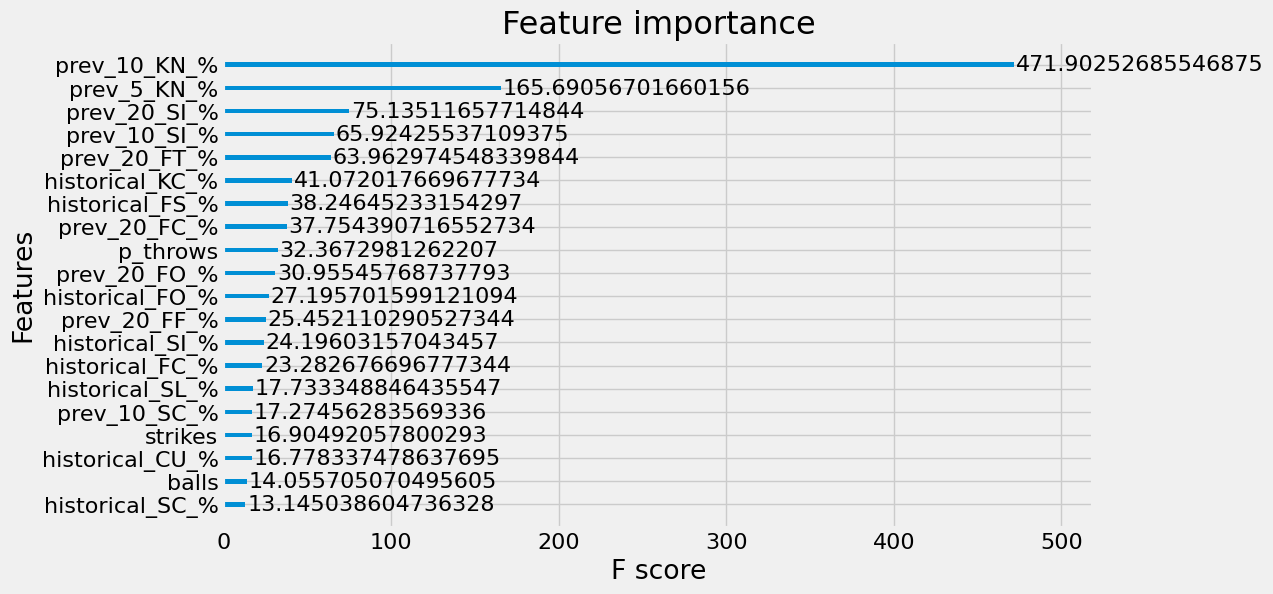

In [22]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.savefig(f"{DIRECTORY_PATH}/feature_importance.png", bbox_inches = 'tight')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
y_test_pred = clf.predict(test_X)

In [28]:
accuracy_score(test_y, y_test_pred)

0.3840002248738598

In [26]:

print('\n------------------ TEST DATA Confusion Matrix -----------------\n')
test_cmatrix = confusion_matrix(test_y, y_test_pred)
print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ TEST DATA Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)
print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())))
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())), file=text_file)



------------------ TEST DATA Confusion Matrix -----------------

       FF    SL    CU    SI    FC    FT   KC    CH   KN   FS  FO  EP  SC
FF  17308  2625   814   551   579  1468   86   919   51  148   3   0   0
SL   4308  4543   245   561    90   611    4   248    0   83   1   0   3
CU   2225   489  1499   229   422   713    4   319   12   40   0   0   0
SI    919  1707   433  3258   474    21   28   850    0  154   0   0   0
FC   1489   229   360   185  1623   263   30   272    0    8   0   0   0
FT   2692   919   444    28   137  3535   16   410    0   27   0   0   1
KC    395    19     0   111    21    43  186   103    0    0   0   0   0
CH   2992   576   362   476   336   742   59  1621    0   12   0   0   0
KN     12     0     0     0     0     0    0     0  293    0   0   1   0
FS    427    78    38    57    41    94    0    16    0  279   0   0   0
FO      8     0     0     0     0     1    0     0    0    0  11   0   0
EP      3     0     1     0     0     0    0     0    9   

In [36]:
''' 
Checking outputs
'''

' \nChecking outputs\n'

In [41]:
def view_pitcher_results(pitcher_id, training_set, validation_set, filepath=None):
    pid = pitcher_id
    num_in_training = training_set.query("pitcher_id == @pid").shape[0]
    num_in_validation = validation_set.query("pitcher_id == @pid").shape[0]

    training_pitch_type_rates = training_set.query("pitcher_id == @pid").pitch_type.value_counts(normalize=True)
    #validation_pitch_type_rates = training_set.query("pitcher_id == @pid").pitch_type.value_counts(normalize=True)

    predictions = clf.predict(validation_set.query("pitcher_id == @pid"))
    true_vals = validation_set.query("pitcher_id == @pid")['pitch_type'].map(mapping)
    pitcher_confusion_matrix = confusion_matrix(true_vals, predictions, labels=list(mapping.values()))

    if filepath is None:
        print(f"Num instances of pitcher {pid} in training set = {num_in_training}")
        print(f"Num instances of pitcher {pid} in validation set = {num_in_validation}")
        print(f"Training rates = \n {pd.DataFrame(training_pitch_type_rates).T} ")

        print(f"Confusion matrix for Pitcher {pid} :")
        print(f"{pd.DataFrame(pitcher_confusion_matrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")
        print(f"Classification Report : ")
        print(classification_report(true_vals, predictions, zero_division=np.nan))
    else:
        with open(filepath, "a") as text_file:
            print(f'\n------------------ Pitcher {pid}: -----------------\n', file=text_file)
            print(f"Training n = {num_in_training}", file=text_file)
            print(f"Val n = {num_in_validation}", file=text_file)
            print(f"Training rates = \n {pd.DataFrame(training_pitch_type_rates).T} ", file=text_file)

            print(f"Confusion matrix for Pitcher {pid} :", file=text_file)
            print(f"{pd.DataFrame(pitcher_confusion_matrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)
            print(f"Classification Report : ", file=text_file)
            print(classification_report(true_vals, predictions, zero_division=np.nan), file=text_file)
    

In [42]:
view_pitcher_results(407819, training_set, validation_set)
view_pitcher_results(407819, training_set, validation_set, MODEL_INFO_FILEPATH)

UndefinedVariableError: name 'pitcher_id' is not defined

In [ ]:
# does well in case where little diversity
view_pitcher_results(547973, training_set, validation_set)
view_pitcher_results(547973, training_set, validation_set, MODEL_INFO_FILEPATH)

Num instances of pitcher 547973 in training set = 661
Num instances of pitcher 547973 in validation set = 107
Training rates = 
 pitch_type       FF        SL        CH   CU   EP   FC   FO   FS   FT   KC  \
proportion  0.83056  0.163389  0.006051  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

pitch_type   KN   SC   SI  
proportion  0.0  0.0  0.0   
Confusion matrix for Pitcher 547973 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF  90   1   0   0   0   0   0   0   0   0   0   0   0
SL  16   0   0   0   0   0   0   0   0   0   0   0   0
CU   0   0   0   0   0   0   0   0   0   0   0   0   0
SI   0   0   0   0   0   0   0   0   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   0   0   0   0   0   0   0   0   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0   0   0
FO   0   0   0

In [ ]:
# view pitcher with no four seam
view_pitcher_results(599899, training_set, validation_set)
view_pitcher_results(599899, training_set, validation_set, MODEL_INFO_FILEPATH)


Num instances of pitcher 599899 in training set = 637
Num instances of pitcher 599899 in validation set = 54
Training rates = 
 pitch_type        SI        CU        SC        SL        CH   EP   FC   FF  \
proportion  0.547881  0.295133  0.076923  0.051805  0.028257  0.0  0.0  0.0   

pitch_type   FO   FS   FT   KC   KN  
proportion  0.0  0.0  0.0  0.0  0.0   
Confusion matrix for Pitcher 599899 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF   0   0   0   0   0   0   0   0   0   0   0   0   0
SL   0   0   0   7   0   0   0   0   0   0   0   0   0
CU   0   0   4  17   0   0   0   0   0   0   0   0   0
SI   0   0   4  17   0   0   0   0   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   0   0   1   1   0   0   0   1   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0  

In [ ]:

view_pitcher_results(115817, training_set, validation_set)
view_pitcher_results(115817, training_set, validation_set, MODEL_INFO_FILEPATH)

Num instances of pitcher 115817 in training set = 2483
Num instances of pitcher 115817 in validation set = 179
Training rates = 
 pitch_type        SI        SL        CU        FF        CH   EP   FC   FO  \
proportion  0.353605  0.271043  0.153443  0.123238  0.098671  0.0  0.0  0.0   

pitch_type   FS   FT   KC   KN   SC  
proportion  0.0  0.0  0.0  0.0  0.0   
Confusion matrix for Pitcher 115817 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF  11  16   1  13   0   0   0   2   0   0   0   0   0
SL   4  29   1  12   0   0   0   2   0   0   0   0   0
CU   1   7   4   6   0   0   0   1   0   0   0   0   0
SI   2  20   2  26   0   0   0   3   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   2   2   2  10   0   0   0   0   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0